In [1]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_roc_curve


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
#from sklearn.model_selection import StratifiedKFold


import xgboost as xgb
#from sklearn.metrics import cross_validation   #Additional scklearn functions
#from sklearn.model_selection import GridSearchCV   #Perforing grid search

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier


/home/emmanuel/miniconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

# Create the Data Set

In [13]:
DAYS_WEIGHT = 90

time_1 = datetime.now()

# If we want matches only between only ranked teams
df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]


df_two_year = df_map[ (df_map['date']>datetime(2018,1,1)) ]


dict_train = {}

print( len( df_tmp['map_id']) )



# Function to append values of all the players
def append_val(team_01,stat_vec,stat_name,dict_inout):

    n = len(stat_vec)
    order = np.argsort( stat_vec )[::-1][:n]

    count_p = -1
    for ind in order:
        count_p = count_p + 1
        dict_inout['t_'+team_01+'_p_'+str(count_p)+'_'+stat_name] = stat_vec[ind]
    
    return dict_inout
    

#2000 -> ~4min
for map_id in df_tmp['map_id'][:1000]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    team_id_1 = df_tmp.loc[map_id]['team_id_1']
    team_id_2 = df_tmp.loc[map_id]['team_id_2']

    winner = df_tmp.loc[map_id]['winner']

    if rank_1 < rank_2:
        # Team_1 is the favorite

        fav = 0
        
        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

        dict_train[map_id]['rank_fav'] = rank_1
        dict_train[map_id]['rank_dog'] = rank_2


    else:
        # Team_2 is the favorite

        fav = 1  

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

        dict_train[map_id]['rank_fav'] = rank_2
        dict_train[map_id]['rank_dog'] = rank_1

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1

        rating_vec    = []
        prize_rtg_vec = []
        hs_vec        = []
        kills_per_rd_vec  = []
        deaths_per_rd_vec = []
        adr_vec = []
        kast_vec = []
        assists_per_rd_vec = []
        flash_per_rd_vec   = []
        first_kills_dif_vec = []
        team_rank_vec = []
        score_dif_vec = []
        win_rate_vec = [] 

        for player_id in dict_map[map_id][team_id]['players_id']:            

            
            # Get the data for this player
            df_aux   = dict_player[player_id]
            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            # Note the prize rating we take a whole year back
            prize = df_aux[ (date_vec>1) & (date_vec<365) ]['prize'].sum()
            if prize > 0.0:
                prize_rtg_vec.append( np.log( prize )/12.0 )
            else:
                prize_rtg_vec.append( 0.0 )

            df_aux   = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]
            # df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) & (df_aux['map']==df_tmp.at[map_id,'map']) ]

            # Append the average values of this player 
            rating_vec.append         ( df_aux['rating'].mean() )
            hs_vec.append             ( (df_aux['hs_kills']/(df_aux['team_score']+df_aux['op_score'])).mean() )        
            kills_per_rd_vec.append   ( df_aux['kills_per_round'].mean() )
            deaths_per_rd_vec.append  ( df_aux['deaths_per_round'].mean() )
            adr_vec.append            ( df_aux['ADR'].mean() )
            kast_vec.append           ( df_aux['KAST'].mean() )
            assists_per_rd_vec.append ( (df_aux['assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            flash_per_rd_vec.append   ( (df_aux['flash_assists']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            first_kills_dif_vec.append( (df_aux['first_kills_diff']/(df_aux['team_score']+df_aux['op_score'])).mean() )
            team_rank_vec.append      ( df_aux['team_rank'].mean() )
            score_dif_vec.append      ( (df_aux['team_score']-df_aux['op_score']).mean() )
            win_rate_vec.append       ( df_aux['win'].mean() )


        if count_team == fav:
            t = '0'
            
        else:
            t = '1'

        dict_train[map_id] = append_val(t,prize_rtg_vec,'prize_rating',dict_train[map_id])

        dict_train[map_id] = append_val(t,rating_vec,'rating',dict_train[map_id])
        dict_train[map_id] = append_val(t,hs_vec,'hs_perc',dict_train[map_id])
        dict_train[map_id] = append_val(t,kills_per_rd_vec,'kills_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,deaths_per_rd_vec,'deaths_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,adr_vec,'adr',dict_train[map_id])
        dict_train[map_id] = append_val(t,kast_vec,'kast',dict_train[map_id])
        dict_train[map_id] = append_val(t,assists_per_rd_vec,'assists_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,flash_per_rd_vec,'flash_per_rd',dict_train[map_id])
        dict_train[map_id] = append_val(t,first_kills_dif_vec,'first_kills_dif',dict_train[map_id])
        dict_train[map_id] = append_val(t,team_rank_vec,'team_rank',dict_train[map_id])
        dict_train[map_id] = append_val(t,score_dif_vec,'score_dif',dict_train[map_id])
        dict_train[map_id] = append_val(t,win_rate_vec,'win_rate',dict_train[map_id])


        # n = len(rating_vec)
        # order = np.argsort( rating_vec )[::-1][:n]

        # if count_team == fav:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = rating_vec[ind]
                
        # else:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = rating_vec[ind]
                

        # if count_team == fav:

        #     dict_train[map_id]['t0_prize'] = np.average( prize )
        #     dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            
        # else:

        #     dict_train[map_id]['t1_prize'] = np.average( prize )
        #     dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            
    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

10466


In [49]:
df_train = pd.DataFrame.from_dict(dict_train,orient='index')

#df_train.head(n=100)['t_0_p_2_score_dif']
df_train.head()

,fav_win,rank_fav,rank_dog,t_0_p_0_prize_rating,t_0_p_1_prize_rating,t_0_p_2_prize_rating,t_0_p_3_prize_rating,t_0_p_4_prize_rating,t_0_p_0_rating,t_0_p_1_rating,...,t_1_p_0_score_dif,t_1_p_1_score_dif,t_1_p_2_score_dif,t_1_p_3_score_dif,t_1_p_4_score_dif,t_1_p_0_win_rate,t_1_p_1_win_rate,t_1_p_2_win_rate,t_1_p_3_win_rate,t_1_p_4_win_rate
79922,0,77,86,0.660299,0.660299,0.575646,0.000000,0.000000,1.14,1.065000,...,0.636364,0.529412,0.529412,0.081081,0.081081,0.545455,0.529412,0.529412,0.486486,0.486486
79923,0,77,86,0.660299,0.660299,0.575646,0.000000,0.000000,1.14,1.065000,...,0.636364,0.529412,0.529412,0.081081,0.081081,0.545455,0.529412,0.529412,0.486486,0.486486
79943,1,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412
79945,0,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412
79947,0,72,152,0.740634,0.731630,0.724612,0.724612,0.724612,1.25,1.110189,...,2.769231,2.769231,2.117647,0.774194,0.466667,0.615385,0.615385,0.555556,0.548387,0.529412


In [59]:
# filename = 'dict_train.sav'
# pickle.dump( dict_train, open(filename,'wb') )

In [5]:
# Here we do some feature engineering
df_all_feat = pd.DataFrame.from_dict(dict_train,orient='index')

df_all_feat = df_all_feat.fillna(0)

df_train = pd.DataFrame()
df_train['fav_win'] = df_all_feat['fav_win']

feat_names = ['prize_rating','rating','hs_perc','kills_per_rd','deaths_per_rd','adr',
                'kast','assists_per_rd','flash_per_rd','first_kills_dif','team_rank','score_dif','win_rate']


for feat in feat_names:
    avg_0 = 0.0
    avg_1 = 0.0
    for ind in range(0,5):
        # df_train[feat+'_p_'+str(ind)+'_dif'] = df_all_feat['t_0_p_'+str(ind)+'_'+feat] - df_all_feat['t_1_p_'+str(ind)+'_'+feat]
       avg_0 = avg_0 + df_all_feat['t_0_p_'+str(ind)+'_'+feat]
       avg_1 = avg_1 + df_all_feat['t_1_p_'+str(ind)+'_'+feat]

    df_train[feat+'_dif'] = ( avg_0 - avg_1 ) / 5.0

# Does it help if we normalize everything?
for column in df_train:
    if column != 'fav_win':
        df_train[column] = (df_train[column]-df_train[column].mean())/df_train[column].std()



#print(df_train.keys())

print(df_train['fav_win'].mean())

df_train.tail(n=80)

0.578


,fav_win,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,assists_per_rd_dif,flash_per_rd_dif,first_kills_dif_dif,team_rank_dif,score_dif_dif,win_rate_dif
81493,1,-0.552294,0.211620,0.633770,-0.099516,-0.767221,-0.142348,0.482265,0.060124,-0.321264,0.083219,-0.358173,-0.010445,-0.018706
81495,0,-1.723131,-0.020978,0.637726,-0.080649,-0.094879,-0.245182,-0.157603,-0.578173,-0.064122,0.059591,-0.916862,0.053458,-0.018706
81497,0,0.470045,-0.239674,-0.089354,-0.200209,-0.042181,-0.153469,-0.183175,0.107216,0.326986,-0.471104,-1.709511,-0.575137,-0.392262
81501,1,0.760236,0.328840,-0.208111,0.146979,-0.411375,0.105708,0.281517,0.355748,-0.338024,0.332168,-0.487649,0.351020,-0.275207
81503,1,0.470045,0.630820,0.385285,0.369913,-0.788771,0.317920,0.362630,0.499522,0.664871,1.268198,-1.454378,1.494937,1.165647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81618,0,-0.928907,-0.061629,-0.376008,-0.198747,-0.138160,-0.083443,-0.088281,0.135266,-0.038129,0.191111,0.516846,-0.202351,-0.332505
81623,0,-0.928907,0.029868,0.040376,0.067574,0.081773,-0.044465,-0.086520,0.658150,0.881258,1.783857,0.426116,0.322764,0.700213
81625,1,0.979770,-0.206979,-0.915914,-0.429389,-0.273303,-0.302568,-0.073022,0.306710,0.295581,-0.221311,0.755864,0.171629,-0.272263
81628,1,0.357924,0.570079,0.430202,0.404876,-0.527045,0.350369,0.405768,-0.052269,-0.278244,0.876929,-0.438604,1.021524,1.035639


# Here we process the results we got

# Now the Logistic regression model

# All models at once

--------------------------------------------------------------
Logistic

>               precision    recall  f1-score   support

Underdog wins       0.52      0.33      0.40       109
Favorite wins       0.60      0.77      0.67       141

     accuracy                           0.58       250
    macro avg       0.56      0.55      0.54       250
 weighted avg       0.56      0.58      0.55       250

[[ 36  73]
 [ 33 108]]
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.51      0.44      0.47       109
Favorite wins       0.61      0.67      0.64       141

     accuracy                           0.57       250
    macro avg       0.56      0.55      0.55       250
 weighted avg       0.56      0.57      0.56       250

[[48 61]
 [47 94]]
--------------------------------------------------------------
Random Forest

>               precision    recall  f1-score   support

Underdog w

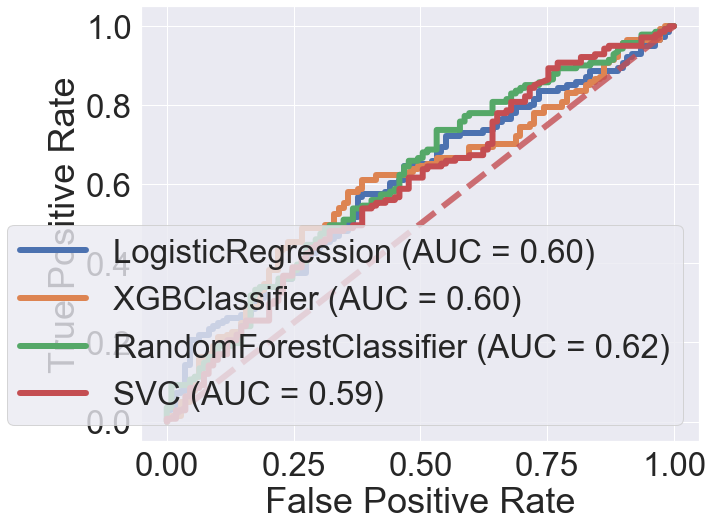

In [7]:
df_tmp = df_train.copy()

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('--------------------------------------------------------------')
print('Logistic')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

# accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
# print(accuracy)

# y_scores = logmodel.predict_proba(X_test)[:,1]

# roc_auc_score(y_test, y_scores)


# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# c_mat = confusion_matrix(y_test, predictions)
# print( c_mat )

print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )




# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

clf = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=1,bootstrap=True)
clf.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf.predict(X_test)

print('--------------------------------------------------------------')
print('Random Forest')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )


# SVM
clf_svm = svm.SVC(probability=True)
clf_svm.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf_svm.predict(X_test)

print('--------------------------------------------------------------')
print('Support Vector Machines')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )



# AUC ROC
sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf_svm, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

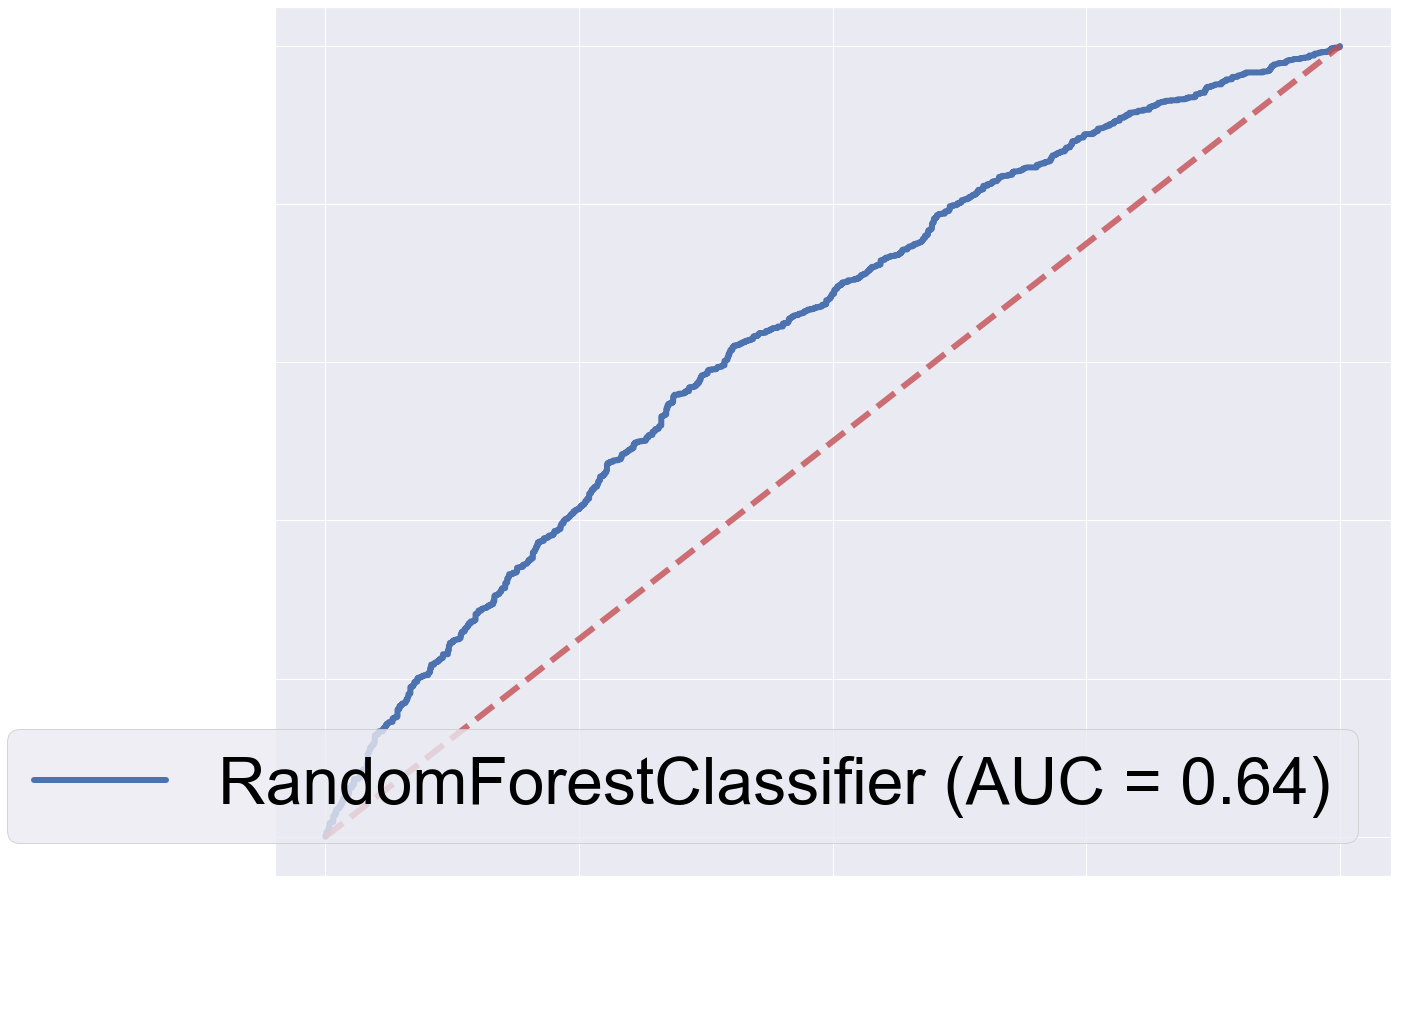

In [155]:
sns.set_style("whitegrid")
sns.set(font_scale=6)


mpl.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})

plt.figure(figsize=(20,16));



ax = plt.axes()

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.savefig('roc.svg', transparent=True, bbox_inches="tight")

plt.show()

In [132]:
df_a.keys()[:]

Index(['prize_rating_dif', 'rating_dif', 'hs_perc_dif', 'kills_per_rd_dif',
       'deaths_per_rd_dif', 'adr_dif', 'kast_dif', 'assists_per_rd_dif',
       'flash_per_rd_dif', 'first_kills_dif_dif', 'team_rank_dif',
       'score_dif_dif', 'win_rate_dif'],
      dtype='object')

In [55]:
X_test

,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,assists_per_rd_dif,flash_per_rd_dif,first_kills_dif_dif,team_rank_dif,score_dif_dif,win_rate_dif
86565,-0.557285,0.332396,-0.443896,0.265897,-0.399481,0.138138,0.342990,-0.039024,-0.149311,0.266122,-0.302208,0.164410,0.307174
93536,1.630243,-2.197906,-0.477898,-2.332818,-1.848264,-2.315403,-2.649863,-2.530094,-1.731077,-0.266395,-1.115689,-0.742479,-1.846872
83948,-0.384481,2.117233,2.082018,2.281470,1.779871,2.492024,2.533926,1.317666,0.811784,1.023670,0.048718,0.533655,0.924199
85213,-0.855967,0.189297,-0.474572,-0.158415,-0.453478,-0.285501,0.174215,0.873691,1.378265,0.379212,0.405701,0.181177,0.792308
94086,-0.951058,-0.479331,-0.256286,-0.347953,0.437894,-0.293418,-0.496349,0.660417,0.793448,0.120780,0.027290,-0.652673,-0.296601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97427,3.464561,1.832332,1.722044,1.911825,1.641583,2.048627,2.131196,-0.516749,0.771890,-0.412069,1.274226,-0.166685,0.033371
87422,2.572093,0.434634,-0.530315,0.405191,-0.517466,0.322220,0.224632,1.025475,1.373165,-0.241645,-2.256338,1.020679,1.031338
90655,-0.563873,-0.626403,-0.828803,-0.545922,0.582180,-0.561125,-0.358509,0.157946,-0.105926,-0.825645,0.419762,-0.961917,-0.674647
84479,0.190154,-0.535027,-0.338942,-0.786542,0.074693,-0.638399,-0.451045,-0.664983,0.024908,-0.149427,-0.842758,-0.395430,-0.580305


Feature ranking:
1. feature 0, $\Delta$ Prize Rating (0.179924)
2. feature 6, $\Delta$ KAST (0.080366)
3. feature 10, $\Delta$ Rank (0.076097)
4. feature 5, $\Delta$ ADR (0.075769)
5. feature 12, $\Delta$ Win % (0.072508)
6. feature 1, $\Delta$ Rating (0.068738)
7. feature 3, $\Delta$ Kills (0.066354)
8. feature 7, $\Delta$ Assists (0.065640)
9. feature 9, $\Delta$ First Kills (0.064018)
10. feature 2, $\Delta$ HS % (0.063680)
11. feature 11, $\Delta$ Score (0.062426)
12. feature 4, $\Delta$ Deaths (0.062260)
13. feature 8, $\Delta$ Flash (0.062222)


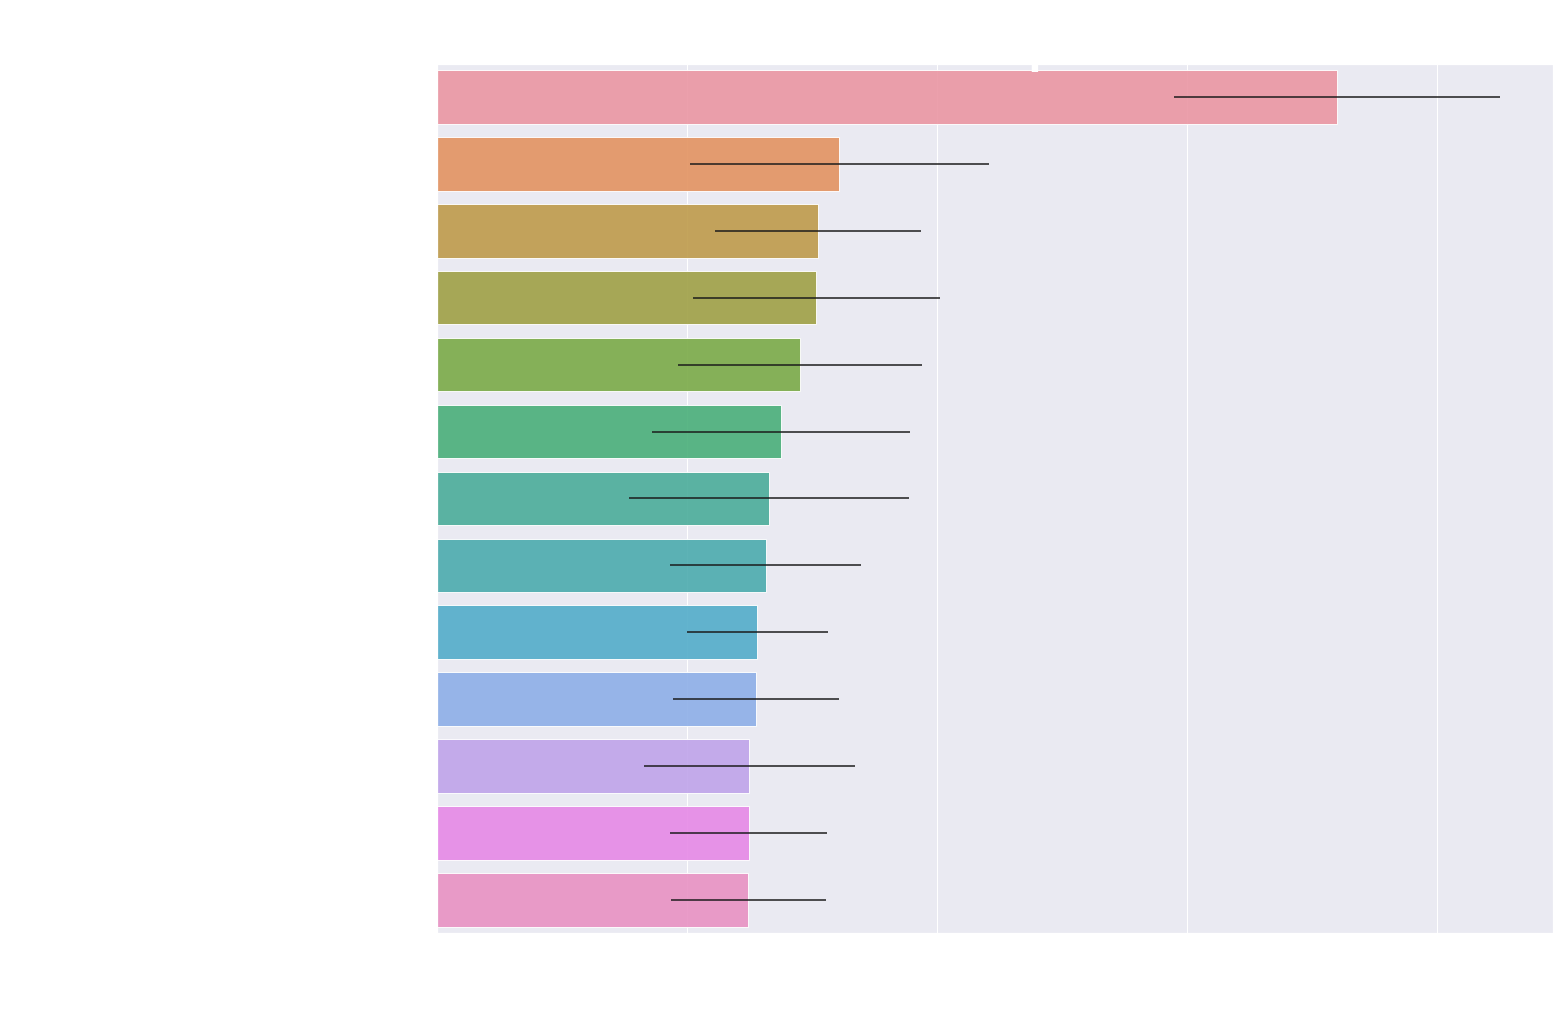

In [150]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)


# importances = logmodel.coef_[0,:]
# std = importances * 0.0

#std = 0.0*logmodel.coef_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


df_a = df_tmp.drop(['fav_win'],axis=1)
vec = df_a.keys()[:]


vec = ['$\Delta$ Prize Rating', '$\Delta$ Rating', '$\Delta$ HS %', '$\Delta$ Kills',
       '$\Delta$ Deaths', '$\Delta$ ADR', '$\Delta$ KAST', '$\Delta$ Assists',
       '$\Delta$ Flash', '$\Delta$ First Kills', '$\Delta$ Rank',
       '$\Delta$ Score', '$\Delta$ Win %']

for f in range(X_train.shape[1]):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], vec[ indices[f] ],  importances[indices[f]]))

# Plot the feature importances of the forest
%matplotlib inline


sns.set_style("whitegrid")
sns.set(font_scale=6)

plt.figure(figsize=(20,16))

mpl.rcParams.update({'text.color' : "white",
                     'axes.labelcolor' : "white",
                     'xtick.color' : "white",
                     'ytick.color' : "white"})


plt.title("Feature importance")

ax = sns.barplot(y=vec,x=importances[indices],xerr=std[indices],alpha=0.9, capsize=.2, errcolor='red' )


plt.savefig('feature.png', transparent=True, bbox_inches="tight")

# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train.shape[1]])

# plt.bar(importances[indices],range(X_train.shape[1]), 
#        color="r", yerr=std[indices], align="center")
# plt.yticks(range(X_train.shape[1]), indices)
# plt.ylim([-1, X_train.shape[1]])

plt.show()

In [103]:
std

array([0.03258829, 0.02569328, 0.0165668 , 0.02791916, 0.01563082,
       0.02466436, 0.02992091, 0.019171  , 0.01555494, 0.01408958,
       0.02060209, 0.02103593, 0.02434842])

In [ ]:
# filename = 'model_jan30.sav
# pickle.dump( logmodel, open(filename,'wb') )

In [ ]:
df_tmp.keys()

# Hyperparameter tunning with XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [33]:

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    target = 'fav_win'
    if useTrainCV:
        print('a')
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds )
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print('Model Report')
    print('Accuracy : %.4g' % accuracy_score(dtrain[target].values, dtrain_predictions) )
    print('AUC Score (Train): %f' % roc_auc_score(dtrain[target], dtrain_predprob) )
                    
    #feat_imp = pd.Series(alg.booster().get_fscore())# .sort_values(ascending=False)
    # feat_imp = 
    # feat_imp.plot(kind='bar', title='Feature Importances')
    # plt.ylabel('Feature Importance Score')

    plt.title("Feature importance")

    plt.figure(figsize=(10,8))
    ax = sns.barplot(y=predictors,x=alg.feature_importances_,alpha=0.9, capsize=.2, errcolor='red' )


    return alg

In [28]:
df_train.keys()

Index(['fav_win', 'prize_rating_dif', 'rating_dif', 'hs_perc_dif',
       'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif', 'kast_dif',
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'team_rank_dif', 'score_dif_dif', 'win_rate_dif'],
      dtype='object')

In [0]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

a
Model Report
Accuracy : 0.7363
AUC Score (Train): 0.823906
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.53      0.26      0.35      1015
Favorite wins       0.65      0.86      0.74      1602

     accuracy                           0.62      2617
    macro avg       0.59      0.56      0.54      2617
 weighted avg       0.60      0.62      0.58      2617

a
Model Report
Accuracy : 0.8425
AUC Score (Train): 0.925812
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.54      0.40      0.46      1015
Favorite wins       0.67      0.79      0.73      1602

     accuracy                           0.64      2617
    macro avg       0.61      0.59      0.59      2617
 weighted avg       0.62      0.64      0.62      2617

249


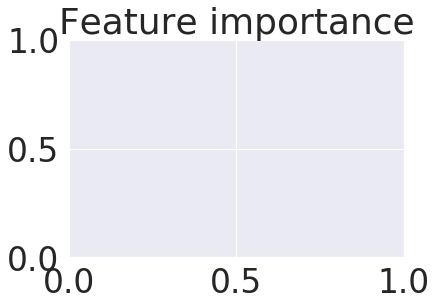

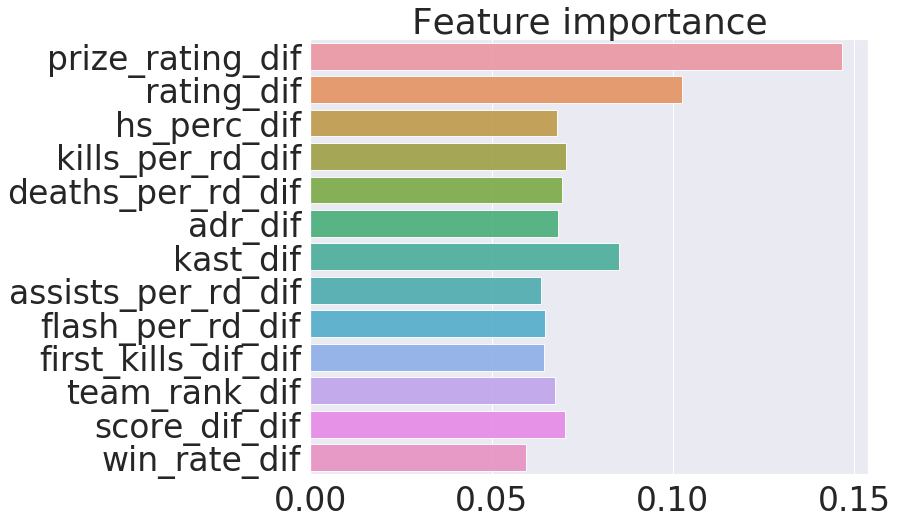

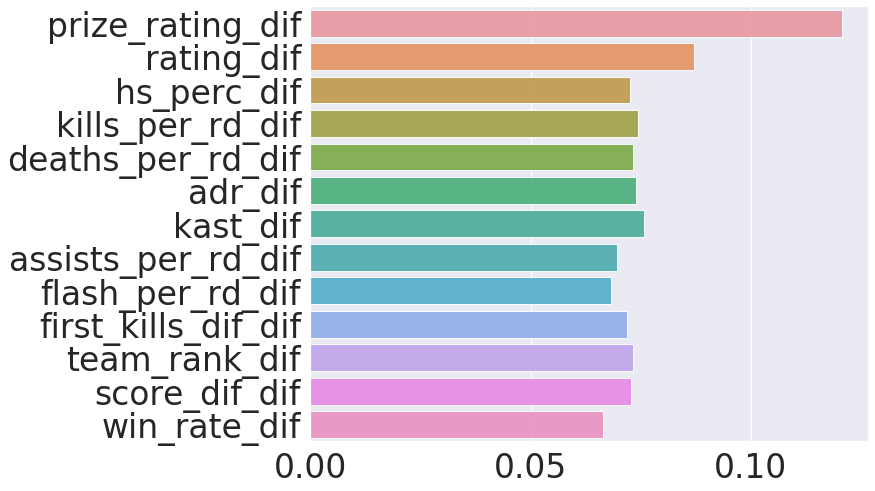

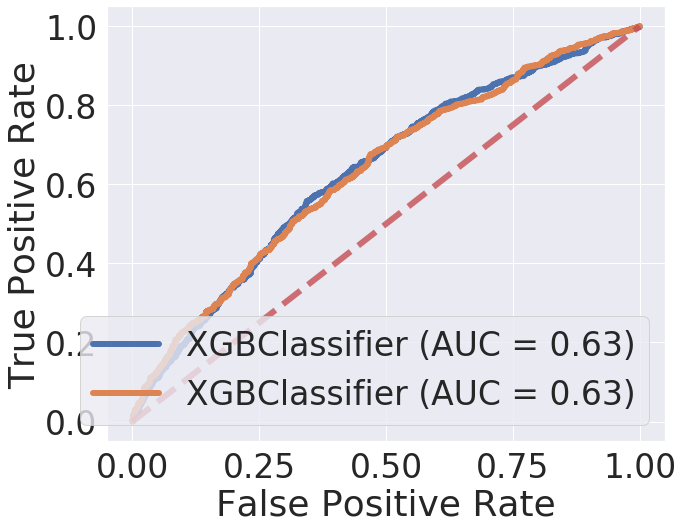

In [77]:
df_tmp = df_train.copy()


#df_tmp = df_tmp[ df_tmp['team_rank_dif']<3 ]

predictors = ['prize_rating_dif', 'rating_dif', 'hs_perc_dif',
       'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif', 'kast_dif',
       'assists_per_rd_dif', 'flash_per_rd_dif', 'first_kills_dif_dif',
       'team_rank_dif', 'score_dif_dif', 'win_rate_dif']

# predictors = ['prize_rating_dif','rating_dif', 'first_kills_dif_dif']

# df_tmp = df_tmp.drop([ 'hs_perc_dif',
#        'kills_per_rd_dif', 'deaths_per_rd_dif', 'adr_dif', 
#        'assists_per_rd_dif', 'flash_per_rd_dif', 'score_dif_dif',
#        'team_rank_dif', 'win_rate_dif','kast_dif' ],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


df_xgb = X_train.copy()
df_xgb['fav_win'] = y_train.values


xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)



xgb1 = modelfit(xgb1, df_xgb, predictors)



# fit model no training data
# model = XGBClassifier()
# model.fit(X_train, y_train)
# make predictions for test data
y_pred = xgb1.predict(X_test)
y_pred1 = y_pred
predictions = [round(value) for value in y_pred]


print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

# c_mat = confusion_matrix(y_test, predictions)
# print( c_mat )

model = XGBClassifier(
    learning_rate =0.1,
    n_estimators=600,
    max_depth=15,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=0)




df_xgb['fav_win'] = df_xgb['fav_win']
model = modelfit(model, df_xgb, predictors)


# model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)

y_pred2 = y_pred
predictions = [round(value) for value in y_pred]


print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

print( np.sum(y_pred1-y_pred2) )



sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP


plot_roc_curve(xgb1, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()



# Cross Validation of the model

In [11]:
df_tmp.mean()

fav_win                5.780000e-01
prize_rating_dif      -2.464695e-17
rating_dif            -1.539047e-17
hs_perc_dif           -2.781109e-17
kills_per_rd_dif      -7.160939e-18
deaths_per_rd_dif      1.881828e-17
adr_dif                1.942890e-18
kast_dif              -2.094158e-17
assists_per_rd_dif     1.943237e-17
flash_per_rd_dif      -2.886580e-18
first_kills_dif_dif    2.331468e-18
team_rank_dif          2.131628e-17
score_dif_dif         -3.511080e-17
win_rate_dif          -1.909584e-17
dtype: float64

--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.42      0.43      0.42       108
Favorite wins       0.56      0.55      0.55       142

     accuracy                           0.50       250
    macro avg       0.49      0.49      0.49       250
 weighted avg       0.50      0.50      0.50       250



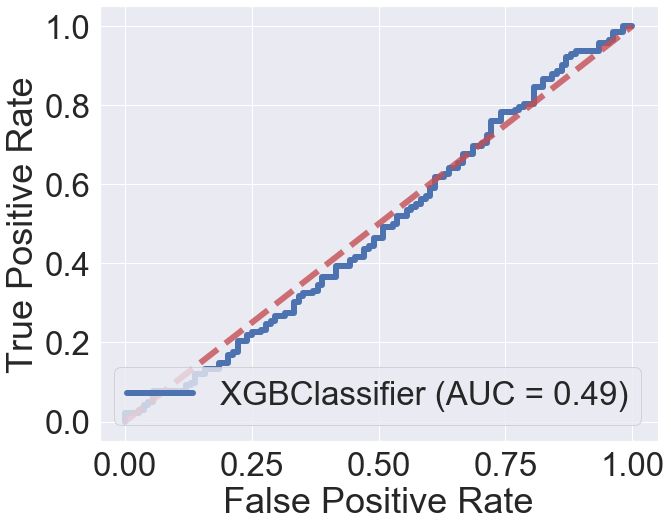

--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.45      0.42      0.44        97
Favorite wins       0.65      0.67      0.66       153

     accuracy                           0.58       250
    macro avg       0.55      0.55      0.55       250
 weighted avg       0.57      0.58      0.57       250



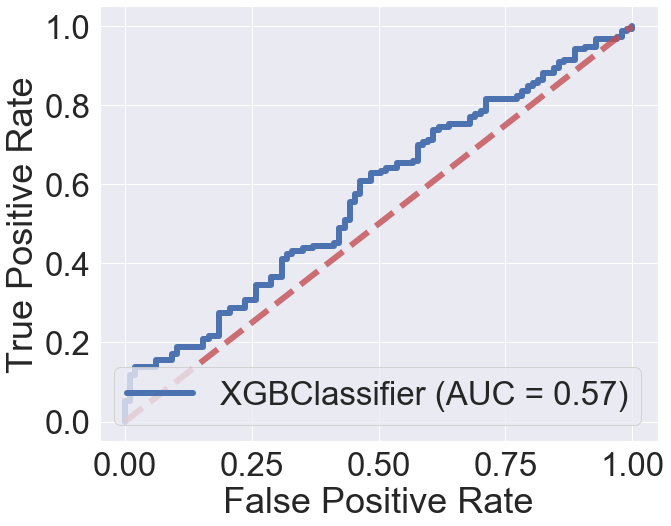

--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.47      0.37      0.42       110
Favorite wins       0.58      0.67      0.62       140

     accuracy                           0.54       250
    macro avg       0.52      0.52      0.52       250
 weighted avg       0.53      0.54      0.53       250



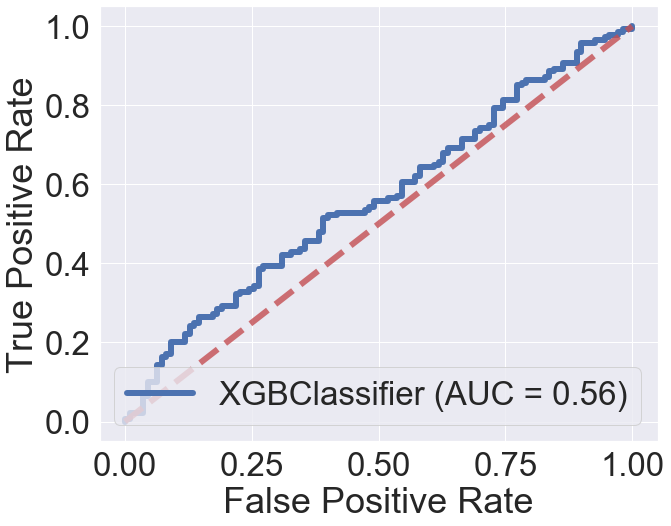

--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.41      0.38      0.40       107
Favorite wins       0.56      0.59      0.57       143

     accuracy                           0.50       250
    macro avg       0.48      0.49      0.48       250
 weighted avg       0.50      0.50      0.50       250



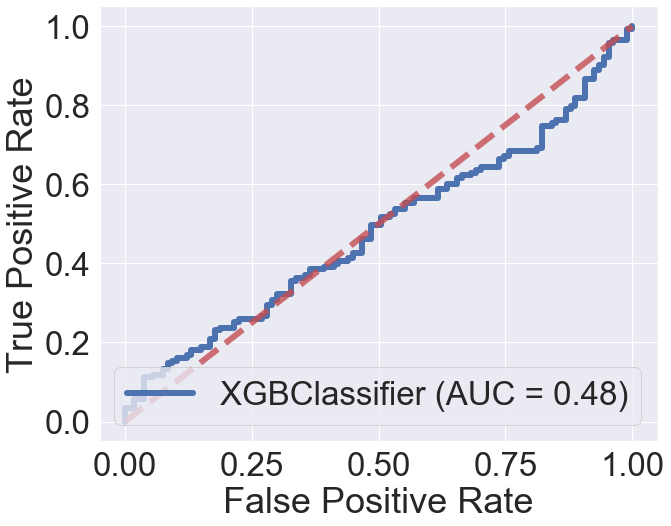

In [12]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# model = XGBClassifier(
#     learning_rate =0.1,
#     n_estimators=600,
#     max_depth=5,
#     min_child_weight=5,
#     gamma=1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=0)

model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=10,
        min_child_weight=1,
        gamma=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1 )


X = df_tmp.iloc[:, [1, 13]]
y = df_tmp.iloc[:, 0].values

# Scale all variables to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


cv = KFold(n_splits=4, random_state=None, shuffle=True)




for train_index, test_index in cv.split(X):
#for test_index, train_index in cv.split(X):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index,:], X[test_index,:], y[train_index], y[test_index]
    # best_svr.fit(X_train, y_train)
    # scores.append(best_svr.score(X_test, y_test))

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    predictions = [round(value) for value in y_pred]


    print('--------------------------------------------------------------')
    print('XGBoost')
    print('')
    print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))


    sns.set_style("whitegrid")
    sns.set(font_scale=3)

    plt.figure(figsize=(10,8));
    ax = plt.axes()

    plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

    ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
            label='Chance', alpha=.8 )

    plt.show()



# model.fit(X_train, y_train)
# make predictions for test data


In [83]:
X_train

,prize_rating_dif,rating_dif,hs_perc_dif,kills_per_rd_dif,deaths_per_rd_dif,adr_dif,kast_dif,assists_per_rd_dif,flash_per_rd_dif,first_kills_dif_dif,team_rank_dif,score_dif_dif,win_rate_dif
89715,1.244057,0.399813,0.473541,0.090855,-0.614239,0.193851,0.304785,1.237785,0.528533,-1.042222,1.157616,1.340319,1.089384
91562,-0.981777,-0.395246,-0.168327,-0.465725,0.085988,-0.527516,-0.308035,-0.101504,0.095168,-0.373526,0.558594,-0.814566,-0.635934
88069,-0.740050,0.324856,1.435217,0.232444,-0.226606,0.257343,0.176936,0.539941,1.241923,0.486211,0.556594,0.552576,0.807854
88381,-1.349273,-0.550173,0.569933,-0.134122,0.694690,-0.219119,-0.473981,-0.762728,-1.455957,-0.907708,0.241759,-0.853155,-0.961826
91464,-0.184428,0.370342,-0.881478,0.189907,-0.541762,0.266304,0.326166,0.108843,-0.933059,-0.010103,-0.711389,0.544085,0.413146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92927,-0.566942,0.506933,0.485921,0.335446,-0.785589,0.298120,0.157375,0.940447,1.498128,0.756998,0.315318,0.603500,0.790636
84168,-1.289389,0.357877,1.191611,0.706136,-0.286744,0.238555,-0.331031,-1.211083,-0.272017,-0.058367,-0.253467,-0.366933,-0.522131
93256,1.920465,0.419958,0.479288,0.355853,-0.378559,0.319796,0.317405,-0.281380,-1.168679,1.061362,1.678728,0.151384,0.205442
81978,2.228703,2.178644,0.728810,1.774154,-2.112450,1.452377,1.726283,1.121912,1.614469,2.582753,2.453527,2.834160,2.685265


In [86]:
# Grid search
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

max_depth_vec = [5, 10, 15]
gamma_vec     = [0, 0.5, 1]

max_depth_vec = [2, 5, 10]
gamma_vec     = [0, 0.5, 1]
min_child_weight_vec = [1, 5, 10]

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10, 15, 20]
        }

X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

# xgb1 = XGBClassifier(
#     learning_rate=0.1,
#     n_estimators=1000,
#     max_depth=5,
#     min_child_weight=1,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=27)



results = {}

count = -1
for max_depth in max_depth_vec:
    for gamma in gamma_vec:
        for min_child_weight in min_child_weight_vec:

            count = count + 1
            results[count] = {}
            results[count]['max_depth'] = max_depth
            results[count]['gamma']     = gamma
            results[count]['min_child_weight'] = min_child_weight
            
        
            print( max_depth, gamma, min_child_weight )

            x1 = XGBClassifier(
                learning_rate =0.1,
                n_estimators=1000,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                gamma=gamma,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1 )
    
    

            x1.fit(X_train,y_train)

            y_pred = x1.predict(X_test)

            predictions = [round(value) for value in y_pred]

            results[count]['recall_underdog'] = recall_score(y_test, y_pred, average=None)[0]
            results[count]['accuracy']        = accuracy_score(y_test, y_pred )

            print('--------------------------------------------------------------')
            print('XGBoost')
            print('')
            print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))


        # sns.set_style("whitegrid")
        # sns.set(font_scale=3)

        # plt.figure(figsize=(10,8));
        # ax = plt.axes()

        # plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

        # ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        #         label='Chance', alpha=.8 )

        # plt.show()



# model.fit(X_train, y_train)
# make predictions for test data


2 0 1
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.56      0.32      0.41       998
Favorite wins       0.67      0.84      0.75      1619

     accuracy                           0.65      2617
    macro avg       0.61      0.58      0.58      2617
 weighted avg       0.63      0.65      0.62      2617

2 0 5
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.55      0.33      0.41       998
Favorite wins       0.67      0.84      0.74      1619

     accuracy                           0.64      2617
    macro avg       0.61      0.58      0.58      2617
 weighted avg       0.62      0.64      0.62      2617

2 0 10
--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.54      0.31      

In [67]:
results

{0: {'max_depth': 10,
  'gamma': 0.5,
  'min_child_weight': 1,
  'recall_underdog': 0.49071358748778104},
 1: {'max_depth': 10,
  'gamma': 0.5,
  'min_child_weight': 5,
  'recall_underdog': 0.47409579667644186},
 2: {'max_depth': 10,
  'gamma': 0.5,
  'min_child_weight': 10,
  'recall_underdog': 0.4887585532746823},
 3: {'max_depth': 10,
  'gamma': 1,
  'min_child_weight': 1,
  'recall_underdog': 0.4858260019550342},
 4: {'max_depth': 10,
  'gamma': 1,
  'min_child_weight': 5,
  'recall_underdog': 0.47996089931573804},
 5: {'max_depth': 10,
  'gamma': 1,
  'min_child_weight': 10,
  'recall_underdog': 0.48484848484848486},
 6: {'max_depth': 15,
  'gamma': 0.5,
  'min_child_weight': 1,
  'recall_underdog': 0.4809384164222874},
 7: {'max_depth': 15,
  'gamma': 0.5,
  'min_child_weight': 5,
  'recall_underdog': 0.4838709677419355},
 8: {'max_depth': 15,
  'gamma': 0.5,
  'min_child_weight': 10,
  'recall_underdog': 0.4897360703812317},
 9: {'max_depth': 15,
  'gamma': 1,
  'min_child_weigh

In [54]:
model = XGBClassifier(
    learning_rate =0.1,
    n_estimators=600,
    max_depth=15,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=0)


X = df_tmp.iloc[:, [1, 13]]
y = df_tmp.iloc[:, 0].values

# Scale all variables to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


cv = KFold(n_splits=10, random_state=42, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model.fit(X_train,y_train,eval_metric='auc')

y_pred = model.predict(X_test)

y_pred2 = y_pred
predictions = [round(value) for value in y_pred]


print('--------------------------------------------------------------')
print('XGBoost')
print('')
print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))





# model.fit(X_train, y_train)
# make predictions for test data


--------------------------------------------------------------
XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.47      0.39      0.43       390
Favorite wins       0.67      0.73      0.70       657

     accuracy                           0.61      1047
    macro avg       0.57      0.56      0.56      1047
 weighted avg       0.59      0.61      0.60      1047



In [24]:
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

df_tmp = df_train.copy()

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

Y = df_tmp['fav_win'].values
X = df_tmp.drop(['fav_win'], axis=1)


# Grid search
# A parameter grid for XGBoost
# learning_rate =0.1,
#     n_estimators=600,
#     max_depth=15,
#     min_child_weight=5,
#     gamma=0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective= 'binary:logistic',
#     nthread=4,
#     scale_pos_weight=1,
#     seed=0)
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10, 15, 20]
        }


xgb = XGBClassifier(learning_rate=0.1, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)


folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=10, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [19]:
# Correlation matrix

correlations = df_tmp.drop(['fav_win'],axis=1).corr()

%matplotlib qt

sns.set_style("whitegrid")
sns.set(font_scale=1)
plt.figure(figsize=(10,8));
ax = plt.axes()

sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, ax=ax)

# Neural Network

https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [ ]:
dataset = df_tmp.values
X = dataset[:,0:15].astype(float)
Y = dataset[:,15]

Y

In [ ]:
# Re-order columns
time_1 = datetime.now()

df_tmp.keys()
df_tmp = df_tmp[['shift_win_rate_0', 'shift_win_rate_1', 't_0_p_0_rating',
       't_0_p_1_rating', 't_0_p_2_rating', 't_0_p_3_rating', 't_0_p_4_rating',
       't_0_avg_rating', 't_1_p_0_rating', 't_1_p_1_rating', 't_1_p_2_rating',
       't_1_p_3_rating', 't_1_p_4_rating', 'rating_dif', 'prize_rating_dif','fav_win']]

# split into input (X) and output (Y) variables
n_input = 15

n_test = 10466

n_splits = 10  # Default 10
n_epochs = 100 # Default 100
n_batch  = 5   # Default 5

dataset = df_tmp.values
X = dataset[0:n_test,0:15].astype(float)
Y = dataset[0:n_test,15]

encoded_Y = Y

# encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)
# with tf.device('/device:GPU:0'):

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(n_input, input_dim=n_input, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
# evaluate model with standardized dataset

estimator = KerasClassifier(build_fn=create_baseline, epochs=n_epochs, batch_size=n_batch, verbose=0)
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

time_2 = datetime.now()

print( time_2-time_1 )